##  Here we will try finding the expected response from a user when supplied with a particular target.

In [33]:
import pymongo
from pymongo import MongoClient
client = MongoClient()
db = client.Cogniable

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

from dateutil.relativedelta import relativedelta
from itertools import product
from tqdm import tqdm_notebook

%matplotlib inline

from fbprophet import Prophet
plt.style.use('fivethirtyeight')

In [2]:
collection = db.parents_skills
parents_skills = pd.DataFrame(list(collection.find()))
parents_skills = parents_skills.iloc[:,1:]
parents_skills = parents_skills[['id','student_id','targets_id','location_id','user_id_id','target_status_id','data_mode','No_of_trails','correct_trails','E_trails','N_trails','response_percentage','session_date']]
parents_skills = parents_skills.astype({'id' : int}) 
parents_skills = parents_skills.drop_duplicates(subset=['id'])
parents_skills = parents_skills.iloc[:,1:]


In [3]:
parents_skills

,student_id,targets_id,location_id,user_id_id,target_status_id,data_mode,No_of_trails,correct_trails,E_trails,N_trails,response_percentage,session_date
0,123,275,12,253,1,teaching,30.0,10.0,0.0,0.0,33.0,2019-01-02
1,123,275,12,253,1,prob,10.0,1.0,9.0,0.0,10.0,2019-01-02
2,123,275,12,253,1,teaching,30.0,30.0,0.0,0.0,100.0,2019-01-02
3,123,276,12,253,1,teaching,30.0,5.0,25.0,0.0,16.0,2019-01-03
4,123,275,12,253,3,teaching,30.0,5.0,25.0,0.0,16.0,2019-01-03
5,123,275,12,253,3,teaching,30.0,5.0,25.0,0.0,16.0,2019-01-03
6,112,392,16,211,4,prob,5.0,5.0,0.0,0.0,100.0,2019-01-03
7,112,392,16,211,4,teaching,7.0,7.0,0.0,0.0,100.0,2019-01-03
8,112,86,16,211,3,prob,1.0,0.0,1.0,0.0,0.0,2019-01-04
9,112,87,16,211,3,prob,1.0,0.0,1.0,0.0,0.0,2019-01-04


In [4]:
labelencoder = LabelEncoder()

X = parents_skills.iloc[:,:7].values
X[:,0] = labelencoder.fit_transform(X[:,0])
X[:,1] = labelencoder.fit_transform(X[:,1])
X[:,2] = labelencoder.fit_transform(X[:,2])
X[:,3] = labelencoder.fit_transform(X[:,3])
X[:,5] = labelencoder.fit_transform(X[:,5])
X[:,5] = labelencoder.fit_transform(X[:,5])
X[:,6] = labelencoder.fit_transform(X[:,6])
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp.fit(X)
X = imp.transform(X)
ohc = OneHotEncoder(categorical_features=[0,1,2,3,4,5,6])
parents_skills_X = ohc.fit_transform(X).toarray()

parents_skills_y = parents_skills.iloc[:,7:-1]
parents_skills_y = np.array(parents_skills_y['response_percentage'])
imp.fit(parents_skills_y.reshape(-1,1))
parents_skills_y = imp.transform(parents_skills_y.reshape(-1,1))
parents_skills_y = parents_skills_y.squeeze()
parents_skills_y = [(l-l%10)/10 for l in parents_skills_y]
ohc = OneHotEncoder()
parents_skills_y = ohc.fit_transform(np.array(parents_skills_y).reshape(-1,1)).toarray()

C:\Users\Piyush\Anaconda3\envs\General\lib\site-packages\sklearn\preprocessing\_encoders.py:392: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


In [5]:
X_train,X_test,Y_train,Y_test = train_test_split(parents_skills_X,parents_skills_y,random_state=0,test_size=0.2)

##  Let's Do Naive Bayes Here 

In [6]:
num_each_class = np.sum(Y_train, axis = 0)
prob_each_class = num_each_class / np.sum(num_each_class)
num_each_class = num_each_class + len(num_each_class)
prob_feature_up = (np.matmul(np.matrix.transpose(X_train), Y_train) + 1) / num_each_class
Imprint = X_test[:, np.newaxis]
Imprint = Imprint.reshape(Imprint.shape[0], Imprint.shape[2], Imprint.shape[1])
Imprint = np.repeat(Imprint, Y_test.shape[1], axis = 2)
prod_class1 = Imprint*prob_feature_up
Imprint_2 = np.zeros(Imprint.shape)
Imprint_2[Imprint == 1] = 0
Imprint_2[Imprint == 0] = 1
prob_feature_down = 1 - prob_feature_up
prod_class2 = Imprint_2*prob_feature_down
prod_class = prod_class1 + prod_class2
prod_class = prod_class.prod(1)
prod_class = prod_class*prob_each_class
predictions = np.argmax(prod_class, axis=1)
predictions = predictions + 1
pd.concat([pd.DataFrame(np.argmax(Y_test, axis=1)+1), pd.DataFrame(predictions)], axis=1)

y_actual = pd.Series((np.argmax(Y_test, axis=1)+1), name='Actual')
y_predicted = pd.Series(predictions, name='Predicted')
df_confusion = pd.crosstab(y_actual, y_predicted)

In [7]:
print("Confusion Matrix:")
print(df_confusion)
df_confusion = np.asmatrix(df_confusion)

Accuracy = float((predictions == (np.argmax(Y_test, axis=1)+1)).sum()) / len(predictions)
print("Accuracy:",Accuracy)

Precision = np.trace(df_confusion) / np.sum(np.triu(df_confusion)) 
print("Precison:",Precision)

Recall = np.trace(df_confusion) / np.sum(np.tril(df_confusion))
print("Recall:",Recall)

F1 = 2*Precision*Recall / (Precision + Recall)
print("F1 Score:", F1)


Confusion Matrix:
Predicted   1   4   5   6   7   9    11
Actual                                 
1          321   5   0  18   0   0   57
2            0   1   0   2   0   0    0
3            6   0   1   2   0   1    1
4            1   9   0   4   0   1    1
5            0   0   1   1   0   1    1
6            2   0   0  17   0   0    7
7            2   3   0   1   0   1    1
8            0   0   0   3   0   0    0
9            0   0   0   2   1   5    0
10           0   0   0   1   0   1    0
11          67   2   0   3   0   3  141
12           1   0   0   0   0   0    0
Accuracy: 0.7067238912732475
Precison: 0.7717647058823529
Recall: 0.5448504983388704
F1 Score: 0.6387536514118792


## We try finding the number of trails to reach a particular response rate for each student 

In [8]:
parents_skills = parents_skills.sort_values(by=['student_id'])

In [9]:
parents_skills['targets_id'].groupby(parents_skills['student_id']).count()

student_id
92     157
94     273
96      11
97      81
99       5
100    176
103    254
104    414
108     12
109     20
110    358
111    386
112    255
115      2
116      2
119      6
123      6
160    165
161     35
163    129
164    242
166    108
173      8
194      4
196    223
202      6
204    130
205     24
207      1
Name: targets_id, dtype: int64

In [10]:
grouped_data = parents_skills.groupby(parents_skills['student_id'])

In [11]:
users = parents_skills.student_id.unique()
users

array([ 92,  94,  96,  97,  99, 100, 103, 104, 108, 109, 110, 111, 112,
       115, 116, 119, 123, 160, 161, 163, 164, 166, 173, 194, 196, 202,
       204, 205, 207], dtype=int64)

In [12]:
individual_data = []
for user in users:
    individual = grouped_data.get_group(user)
    individual = individual.groupby(individual['targets_id'])
    individual_data.append(individual)

In [13]:
user_data = grouped_data.get_group(104) 
user_data = user_data.iloc[:,1:].sort_values(by=['session_date'])
user_data = user_data[['session_date', 'targets_id', 'location_id', 'user_id_id', 'target_status_id', 'data_mode', 'No_of_trails', 'correct_trails', 'E_trails', 'N_trails', 'response_percentage']]
user_data = user_data.drop(['E_trails', 'N_trails', 'location_id', 'user_id_id', 'correct_trails'], axis=1)
user_data = user_data.dropna(subset = ['response_percentage'])

In [14]:
user_data.groupby(parents_skills['targets_id']).count()

,session_date,targets_id,target_status_id,data_mode,No_of_trails,response_percentage
targets_id,,,,,,
436,22,22,22,22,22,22
438,25,25,25,25,25,25
440,25,25,25,25,25,25
441,3,3,3,3,3,3
442,1,1,1,1,1,1
443,17,17,17,17,17,17
444,29,29,29,29,29,29
446,17,17,17,17,17,17
447,2,2,2,2,2,2


In [15]:
user_data_target = individual_data[7].get_group(501)
user_data_target.columns
user_data_target = user_data_target[['session_date','student_id', 'targets_id', 'location_id', 'user_id_id', 'target_status_id', 'data_mode', 'No_of_trails', 'correct_trails', 'E_trails', 'N_trails', 'response_percentage']]
user_data_target = user_data_target.sort_values(by=['session_date'])
user_data_target = user_data_target.dropna(subset = ['response_percentage'])
user_data_target = user_data_target.drop(['E_trails', 'N_trails', 'student_id', 'targets_id', 'location_id', 'user_id_id', 'correct_trails'],axis=1)
user_data_target = user_data_target.set_index(keys=['session_date'])

In [16]:
user_data_target

,target_status_id,data_mode,No_of_trails,response_percentage
session_date,,,,
2019-01-10,3,prob,1.0,0.0
2019-01-24,3,teaching,5.0,0.0
2019-02-19,3,teaching,3.0,66.0
2019-02-19,3,prob,1.0,0.0
2019-02-21,3,prob,1.0,100.0
2019-02-22,3,prob,1.0,0.0
2019-02-25,3,teaching,3.0,33.0
2019-02-25,3,prob,1.0,0.0
2019-03-11,3,teaching,3.0,33.0


##  We will start building time series models and feature engineering for the same now.

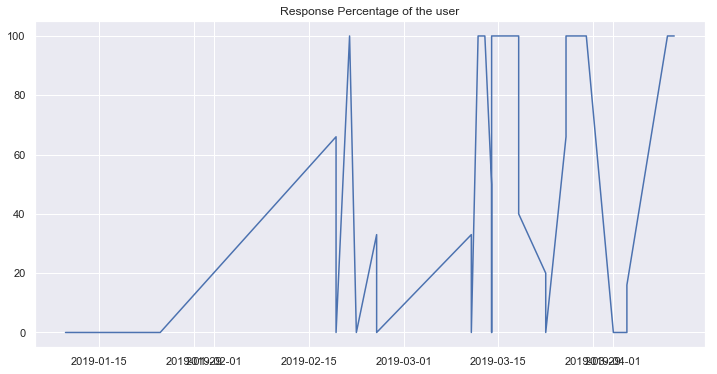

In [17]:
plt.figure(figsize=(12,6))
plt.plot(user_data_target.response_percentage)
plt.title('Response Percentage of the user')
plt.grid(True)
plt.show()

In [18]:
def e_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y-true - y_pred)) * 100)

In [19]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

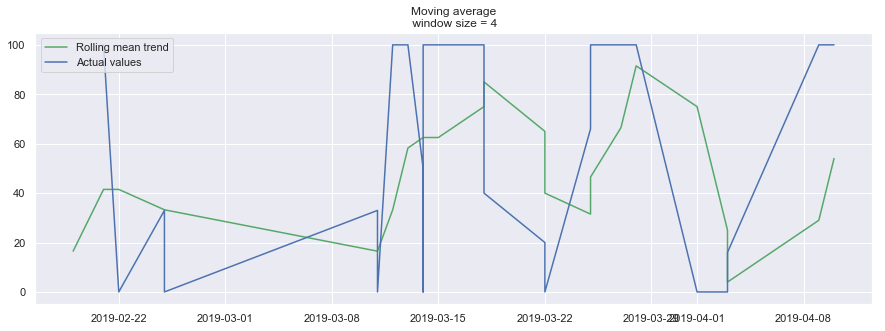

In [20]:
plotMovingAverage(user_data_target.response_percentage, 4)

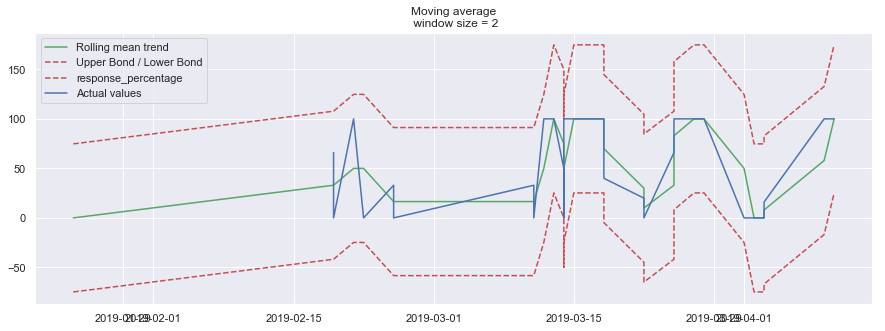

In [21]:
plotMovingAverage(user_data_target.response_percentage, 2, plot_intervals=True)

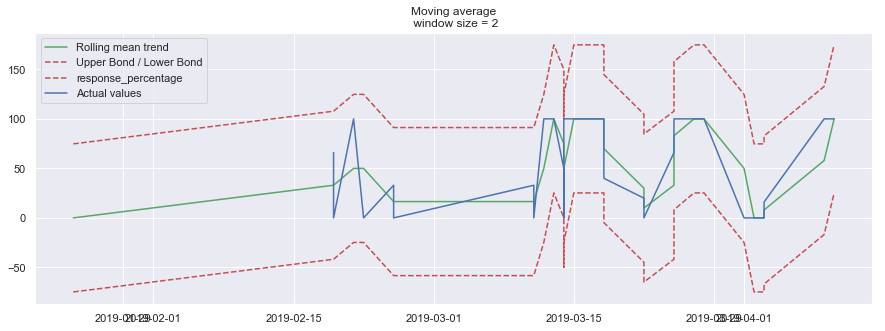

In [22]:
plotMovingAverage(user_data_target.response_percentage, 2, plot_intervals=True, plot_anomalies=True)

In [23]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

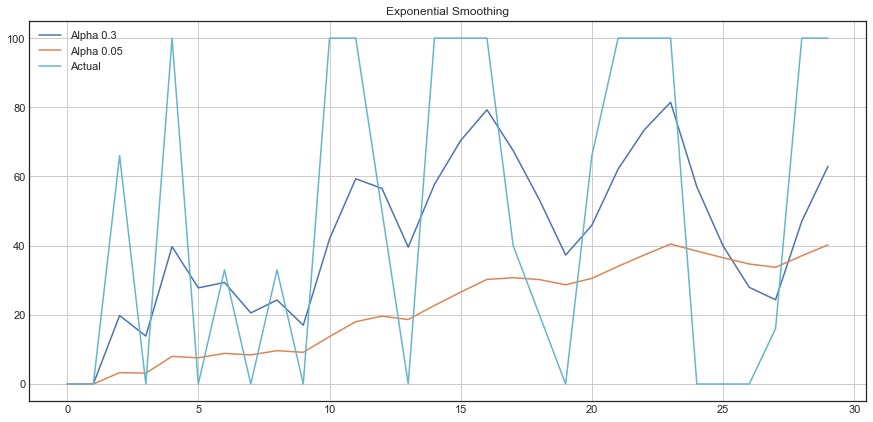

In [24]:
plotExponentialSmoothing(user_data_target.response_percentage, [0.3, 0.05])

##  Here we observe that the exponential smoothing of a learners temporal data indeed follow certain trend.

In [25]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

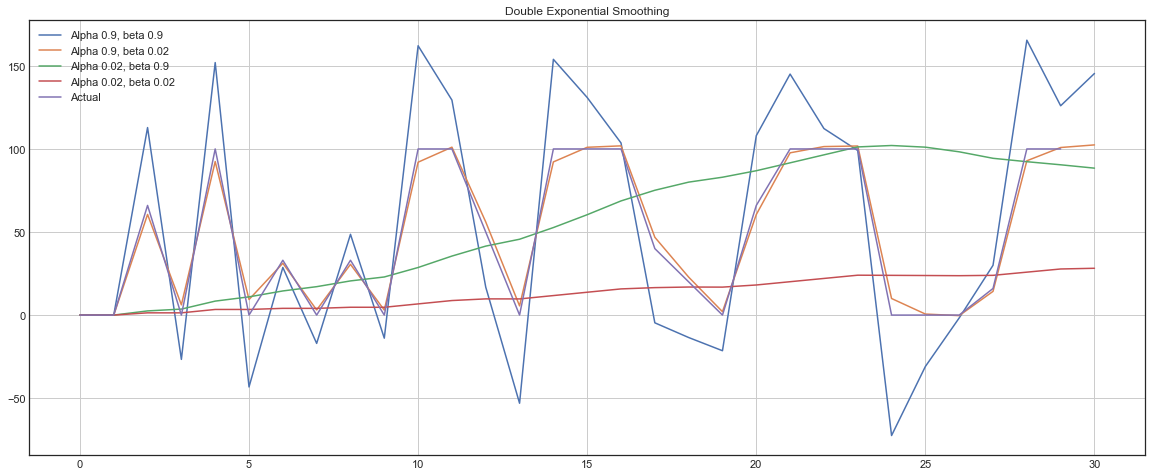

In [26]:
plotDoubleExponentialSmoothing(user_data_target.response_percentage, alphas=[0.9, 0.02], betas=[0.9, 0.02])

# Here the propher library from facebook is used for time series forecasting.

In [43]:
user_data_target = user_data_target.iloc[:,-1:]
user_data_target.reset_index(level=0, inplace=True)

In [46]:
user_data_target = user_data_target.rename(columns={'session_date': 'ds','response_percentage': 'y'})

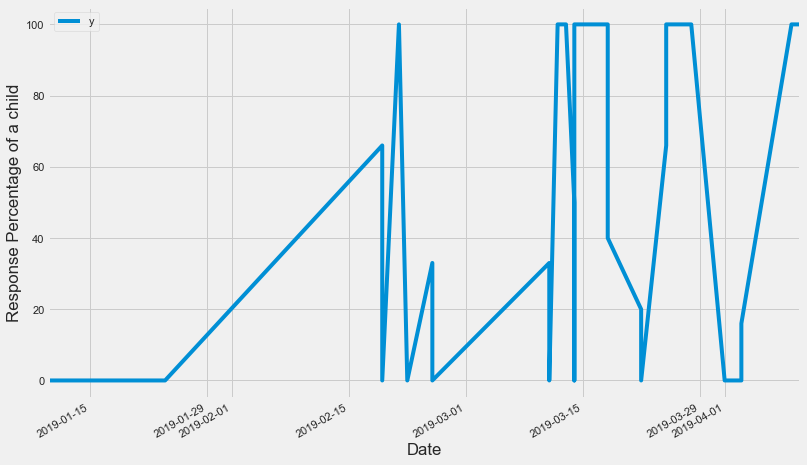

In [48]:
ax = user_data_target.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Response Percentage of a child')
ax.set_xlabel('Date')

plt.show()

In [94]:
my_model = Prophet(interval_width=0.95)

In [95]:
my_model.fit(user_data_target.iloc[:-10,:])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.


In [96]:
future_dates = user_data_target.iloc[-10:,0:1]

In [97]:
forecast = my_model.predict(future_dates)

In [98]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2019-03-25,52.664543,-14.862872,122.990317
1,2019-03-25,52.664543,-9.157653,126.313049
2,2019-03-27,116.229967,56.009418,185.817825
3,2019-03-28,82.203929,16.359664,149.864753
4,2019-04-01,60.466358,-8.274264,133.306726
5,2019-04-02,94.657051,29.454526,159.574507
6,2019-04-03,124.031782,57.581967,191.708687
7,2019-04-03,124.031782,53.493350,190.101344
8,2019-04-09,102.458866,31.660961,163.968601
9,2019-04-10,131.833597,59.382293,197.350101


In [104]:
df1 = user_data_target.iloc[:-10,:]
df2 = forecast.iloc[:,[0,1]]
df2 = df2.rename(columns={'trend': 'y'})
yhat = pd.concat([df1, df2])

df1 = user_data_target.iloc[:-10,:]
df2 = forecast.iloc[:,[0,2]]
df2 = df2.rename(columns={'yhat_lower': 'y'})
yhat_lower = pd.concat([df1, df2])

df1 = user_data_target.iloc[:-10,:]
df2 = forecast.iloc[:,[0,3]]
df2 = df2.rename(columns={'yhat_upper': 'y'})
yhat_upper = pd.concat([df1, df2])

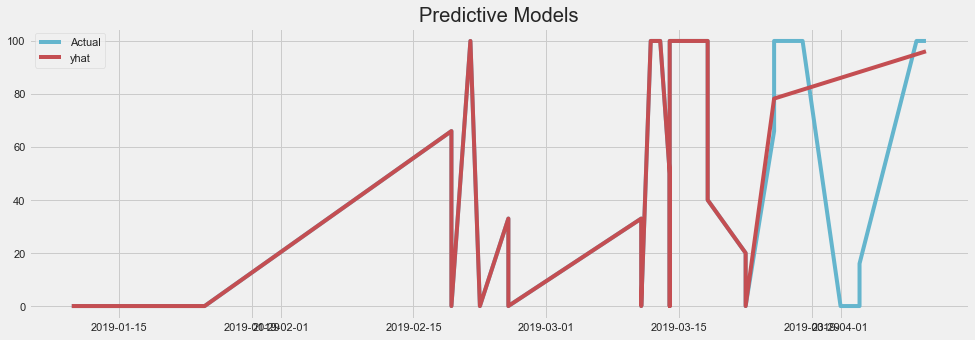

In [106]:
plt.figure(figsize=(15,5))
plt.title("Predictive Models")
plt.plot(user_data_target.ds, user_data_target.y, "c", label="Actual")
plt.plot(yhat.ds, yhat.y, "r", label="yhat")
#uncomment the below 2 lines to see the upper and lower confidence interval
#plot(yhat_lower.ds, yhat_lower.y, "m", label="yhat_lower")
#plt.plot(yhat_upper.ds, yhat_upper.y, "k", label="yhat_upper")
plt.legend(loc="upper left")
plt.grid(True)